In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from tqdm.auto import tqdm
from rl_analysis.plotting import (
    setup_plotting_env,
    clean_plot_labels,
    savefig,
    clean_ticks,
    plot_pval,
    format_pval,
    geno_palette,
)
from sklearn import model_selection
from copy import deepcopy
from rl_analysis.util import whiten, pd_zscore
from rl_analysis.photometry.encoding_average.util import (
    run_inference_and_ppc,
    run_inference,
)
import pandas as pd
import natsort as ns
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
from jax import random
from sklearn import preprocessing
import multiprocessing as mp
import numpyro

numpyro.set_host_device_count(mp.cpu_count())
numpyro.set_platform("cpu")

from rl_analysis.photometry.encoding_average import models

from scipy.stats import zscore
from joblib import Parallel, delayed
from scipy.stats import mannwhitneyu

# Model functions

# Parameters

In [3]:
import toml

with open("../analysis_configuration.toml", "r") as f:
    analysis_config = toml.load(f)

In [4]:
raw_dirs = analysis_config["raw_data"]
proc_dirs = analysis_config["intermediate_results"]
lagged_cfg = analysis_config["dlight_lagged_correlations"]
encoding_cfg = analysis_config["dlight_encoding_features"]
figure_cfg = analysis_config["figures"]

In [5]:
file_suffix = "offline" if lagged_cfg["use_offline"] else "online"
load_file = os.path.join(raw_dirs["dlight"], f"dlight_snippets_{file_suffix}.parquet")

In [6]:
file, ext = os.path.splitext(load_file)
features_save_file = f"{file}_features{ext}"

if lagged_cfg["use_renormalized"]:
    file, ext = os.path.splitext(features_save_file)
    features_save_file = f"{file}_renormalize{ext}"

rle_save_file = features_save_file.replace("snippet", "usage")
dirname, filename = os.path.split(features_save_file)
file, ext = os.path.splitext(filename)
file = os.path.join(proc_dirs["dlight"], file)
if lagged_cfg["estimate_within_bin"]:
    file = f"{file}_withinbin"

results_features_file = f"{file}_encoding_model_average_features.parquet"

In [7]:
use_features = []
for _use_win in lagged_cfg["use_windows"]:
    use_features += [f"{_}_{_use_win}" for _ in lagged_cfg["use_neural_features"]]
scalar_keys = lagged_cfg["usage_and_scalars"]["scalars"]

### Or use 'em all

In [8]:
model_features = pd.read_parquet(results_features_file)
all_lags = [int(_.split("_")[1]) for _ in model_features.filter(regex="count").columns]
include_lags = all_lags

neural_keys = use_features
y = [use_features[0]]
y = ["signal_reref_dff_z_max_(0.0, 0.3)"]

# just for correlation
include_features = ["count", "entropy", "velocity_2d_mm_global_bin"]
include_features += [f"{y[0]}_global_bin"]

# put in features and lags
select_cols = ns.natsorted(
    [f"{_feature}_{_lag}" for _feature in include_features for _lag in include_lags]
)

## Run model

### Fit model to separate lags (individually whitened)

In [9]:
whiten_data = True
use_model = models.simple_regression

In [10]:
use_model_features = model_features[select_cols + y].copy()
use_model_features[select_cols] = use_model_features[select_cols].transform(pd_zscore)

In [11]:
_tmp = use_model_features[select_cols].melt(ignore_index=False)
_tmp["feature"] = _tmp["variable"].str.extract("(.*)_[0-9]*")
_tmp["lag"] = _tmp["variable"].str.extract(".*_([0-9]*)").astype("int")

In [12]:
dfs = []
for _lag in _tmp["lag"].unique():
    _df = (
        _tmp.loc[_tmp["lag"] == _lag]
        .set_index("feature", append=True)["value"]
        .unstack()
    )
    _df["lag"] = _lag
    dfs.append(_df)

In [13]:
use_model_features = pd.concat(dfs).join(use_model_features[y])
use_model_features = use_model_features.set_index("lag", append=True)

In [14]:
X_base = use_model_features.iloc[:, :-1]
Y_base = use_model_features.iloc[:, -1:]

nans = np.isnan(X_base).any(axis=1) | np.isnan(Y_base).any(axis=1)
X_base = X_base[~nans]
Y_base = Y_base[~nans]
powers = 1
new_x = [X_base]
for _power in range(2, powers + 1):
    _new_x = X_base**_power
    _new_x.columns = [f"{_} ** {_power}" for _ in _new_x.columns]
    new_x.append(_new_x)
X_base = pd.concat(new_x, axis=1)
feature_indicator = pd.factorize(
    use_model_features.index.get_level_values("lag").values
)[0]

In [15]:
whiten_group_by = "lag"
if whiten_data:
    if whiten_group_by is None:
        X_base.values[:], W, _ = whiten(X_base.values, method="zca")
    else:
        dfs = []
        for k, grp in X_base.groupby(whiten_group_by):
            grp.values[:], W, _ = whiten(grp.values, method="zca")
            dfs.append(grp)
        X_base = pd.concat(dfs)

In [16]:
use_cols = X_base.columns[~X_base.columns.str.contains("dff")]

In [17]:
X_base = X_base[use_cols]

In [18]:
indicator_map = {"dls": 0, "dms": 1}
indicator_map = {
    k: v for k, v in indicator_map.items() if k in X_base.index.get_level_values("area")
}

In [19]:
samples = {}
ppc = {}

for _lag in tqdm(X_base.index.get_level_values("lag").unique()):
    feature_indicator = (
        X_base.xs(_lag, level="lag").index.get_level_values("area").map(indicator_map)
    ).values

    X = X_base.xs(_lag, level="lag").values
    Y = Y_base.xs(_lag, level="lag").values

    rng_key = random.PRNGKey(0)
    rng_key, rng_key_ = random.split(rng_key)

    samples[_lag] = run_inference(
        X,
        Y.ravel(),
        use_model,
        feature_indicator=feature_indicator,
        rng_key=rng_key_,
        standardize=True,
        ncpus=1,
    )

  0%|          | 0/10 [00:00<?, ?it/s]

In [20]:
setup_plotting_env()
sns.set_context("paper")

In [21]:
ci = 0.95

In [22]:
lo_bound = np.round((1 - ci) / 2, 3)
hi_bound = np.round(1 - lo_bound, 3)

In [23]:
features = X_base.columns

In [24]:
lo_ci = np.array([np.quantile(_["w"], lo_bound, axis=0) for _ in samples.values()]).T
mid_ci = np.array([np.quantile(_["w"], 0.5, axis=0) for _ in samples.values()]).T
hi_ci = np.array([np.quantile(_["w"], hi_bound, axis=0) for _ in samples.values()]).T

In [25]:
plt_lags = [10, 800]
use_w = np.array([_["w"].squeeze() for _ in samples.values()])
setup_plotting_env()
lags = list(samples.keys())

In [26]:
colors = {
    "velocity_2d_mm_global_bin": sns.color_palette()[0],
    "entropy": sns.color_palette()[1],
    "count": sns.color_palette()[7],
}

In [27]:
dcts = []
for i, _lag in enumerate(lags):
    for j, _col in enumerate(use_cols):
        for _indicator_key, _indicator in indicator_map.items():
            pval_l = (use_w[i, :, _indicator, j].squeeze() >= 0).mean()
            pval_r = (use_w[i, :, _indicator, j].squeeze() <= 0).mean()
            dct = {}
            dct["feature"] = _col
            dct["indicator"] = _indicator_key
            dct["pval"] = pval_l
            dct["tail"] = "left"
            dct["lag"] = _lag
            dcts.append(dct)

            dct = {}
            dct["feature"] = _col
            dct["indicator"] = _indicator_key
            dct["pval"] = pval_r
            dct["tail"] = "right"
            dct["lag"] = _lag
            dcts.append(dct)

In [28]:
pval_df = pd.DataFrame(dcts)

In [29]:
pval_df = pval_df.set_index(["tail", "indicator", "feature", "lag"])

In [30]:
from statsmodels.stats.multitest import multipletests

pval_df.values[:] = multipletests(pval_df.values.ravel(), method="holm")[1].reshape(
    pval_df.values.shape
)

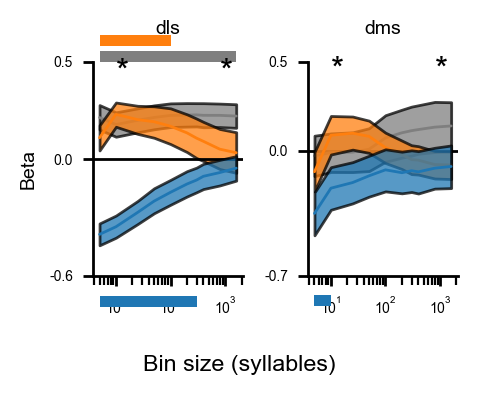

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(2.4, 1.9), sharey=False, sharex=True)
handles = []
zorder = 0
for i, (_area, _ax) in enumerate(zip(indicator_map.keys(), ax)):
    for j, _feature in enumerate(features):
        _handle = _ax.fill_between(
            lags,
            lo_ci[j, i],
            hi_ci[j, i],
            alpha=0.75,
            fc=colors[_feature],
            ec="k",
            lw=1,
            zorder=zorder,
        )
        zorder += 1
        handles.append(_handle)
        _ax.plot(lags, mid_ci[j, i], color=colors[_feature], zorder=zorder)
        zorder += 1
    for _lag in plt_lags:
        _ax.annotate("*", (_lag, 0.4), fontsize=12)

ax[0].set_ylim(-0.6, 0.5)
ax[1].set_ylim(-0.7, 0.5)

for i, (_area, _ax) in enumerate(zip(indicator_map.keys(), ax)):
    use_pval_df = pval_df.xs(("right", _area), level=("tail", "indicator"))
    keys = features
    key_level = "feature"
    use_colors = [colors[_feature] for _feature in features]
    plot_pval(use_pval_df["pval"], keys, key_level, ax=_ax, colors=use_colors, offset=1)

    use_pval_df = pval_df.xs(("left", _area), level=("tail", "indicator"))
    keys = features
    key_level = "feature"
    use_colors = [colors[_feature] for _feature in features]
    plot_pval(
        use_pval_df["pval"],
        keys,
        key_level,
        ax=_ax,
        colors=use_colors,
        position="bottom",
        offset=0.9,
    )
    _ax.set_title(_area, pad=10)


sns.despine()
clean_ticks(ax[0], "y", precision=2, zero_symmetry=False)
clean_ticks(ax[1], "y", precision=2, zero_symmetry=False)

for _ax in ax:
    _ax.set_xscale("log")
    _ax.axhline(y=0, color=plt.rcParams["axes.edgecolor"])
fig.supxlabel("Bin size (syllables)")
ax[0].set_ylabel("Beta")
fig.tight_layout()
savefig(
    fig,
    os.path.join(figure_cfg["store_dir"], "encoding_model_average_lag_scan"),
    bbox_inches="tight",
    dpi=900,
)

In [32]:
use_samples = deepcopy(samples)

In [33]:
dfs = []
for i, _area in enumerate(indicator_map.keys()):
    for _lag in plt_lags:
        plt_samples = deepcopy(use_samples[_lag])
        plt_samples["w"] = plt_samples["w"][:, i, :].squeeze()
        plt_samples["area"] = _area
        ny_cis = numpyro.diagnostics.hpdi(plt_samples["w"], prob=0.99)
        ny_cis = [ny_cis[0], np.quantile(plt_samples["w"], 0.5, axis=0), ny_cis[1]]

        cis = pd.DataFrame(ny_cis, index=["low", "mid", "high"], columns=X_base.columns)
        cis.index.name = "ci"
        cis["lag"] = _lag
        cis["area"] = _area
        dfs.append(cis)

In [34]:
ci_df = pd.concat(dfs).set_index(["lag", "area"], append=True)

In [35]:
cis = ci_df.melt(ignore_index=False, var_name="feature")
cis = cis.set_index("feature", append=True)

In [36]:
plt_features = cis.index.get_level_values("feature").unique().tolist()
plt_features = [_ for _ in plt_features if "dff" not in _]

In [37]:
plt_features

['count', 'entropy', 'velocity_2d_mm_global_bin']

In [38]:
label_map = {
    "velocity_2d_mm_global_bin": "velocity",
    "entropy": "entropy",
    "count": "syllable\ncounts",
}

In [39]:
setup_plotting_env()

In [40]:
print_features = np.unique([_[:3] for _ in plt_features])
suffix = f"lags-{plt_lags}_feature-{print_features}"
features = cis.index.get_level_values("feature").unique()
nfeatures = list(samples.values())[0]["w"].shape[1]
plt_areas = ["dls", "dms"]

##  Held-out (separate fits on all lags)

In [41]:
whiten_data = True
use_model = models.simple_regression
select_cols = ["count_100", "entropy_10", "velocity_2d_mm_global_bin_5"]

use_model_features = model_features[select_cols + y].copy()

In [42]:
use_model_features[select_cols] = use_model_features[select_cols].transform(pd_zscore)

In [43]:
X_base = use_model_features.iloc[:, :-1]
Y_base = use_model_features.iloc[:, -1:]

nans = np.isnan(X_base).any(axis=1) | np.isnan(Y_base).any(axis=1)
X_base = X_base[~nans]
Y_base = Y_base[~nans]
powers = 1
new_x = [X_base]
for _power in range(2, powers + 1):
    _new_x = X_base**_power
    _new_x.columns = [f"{_} ** {_power}" for _ in _new_x.columns]
    new_x.append(_new_x)
X_base = pd.concat(new_x, axis=1)

indicator_variables = ["area", "mouse_id"]
feature_indicator, indicator_map = pd.factorize(
    list(
        zip(
            use_model_features.index.get_level_values("area").values,
            use_model_features.index.get_level_values("mouse_id").values,
        )
    )
)
indicator_map = pd.Series(indicator_map)

In [44]:
if whiten_data:
    from rl_analysis.util import whiten

    X_base.values[:], W, _ = whiten(X_base.values, method="zca_cor")

In [45]:
syllable_cols = X_base.filter(regex=("duration|syllable|entropy|count|tm")).columns
scalars_cols = X_base.filter(regex="bin").columns.difference(syllable_cols)

In [46]:
syllable_idx = [X_base.columns.get_loc(c) for c in syllable_cols]
scalar_idx = [X_base.columns.get_loc(c) for c in scalars_cols]

In [47]:
splits = model_selection.RepeatedKFold(n_splits=5, n_repeats=50)

In [48]:
X = X_base.copy().values
Y = Y_base.copy().values

In [49]:
preproc = preprocessing.StandardScaler()

In [50]:
actual_values_store = []
delays = []
rng_key = random.PRNGKey(0)

for train_idx, test_idx in tqdm(splits.split(X, Y), total=splits.get_n_splits()):
    test_y = preproc.fit_transform(Y[test_idx]).ravel()
    train_x, train_y = zscore(X[train_idx]), zscore(Y[train_idx]).ravel()
    test_x = zscore(X[test_idx])
    if feature_indicator is not None:
        train_ind, test_ind = feature_indicator[train_idx], feature_indicator[test_idx]
    else:
        train_ind, test_ind = None, None

    rng_key, rng_key_ = random.split(rng_key)

    delays.append(
        delayed(run_inference_and_ppc)(
            train_x,
            train_y,
            test_x,
            train_ind,
            test_ind,
            use_model,
            ncpus=1,
            preproc=preproc,
            rng_key=rng_key_,
        )
    )
    delays.append(
        delayed(run_inference_and_ppc)(
            train_x[:, syllable_idx],
            train_y,
            test_x[:, syllable_idx],
            train_ind,
            test_ind,
            use_model,
            ncpus=1,
            preproc=preproc,
            rng_key=rng_key_,
        )
    )
    delays.append(
        delayed(run_inference_and_ppc)(
            train_x[:, scalar_idx],
            train_y,
            test_x[:, scalar_idx],
            train_ind,
            test_ind,
            use_model,
            ncpus=1,
            preproc=preproc,
            rng_key=rng_key_,
        )
    )
    actual_values_store.append(preproc.inverse_transform(test_y[:, None]))
print(len(delays))
results = Parallel(verbose=10, n_jobs=-1)(delays)

  0%|          | 0/250 [00:00<?, ?it/s]

750


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 128 concurrent workers.
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more

In [51]:
all_variables, syllables_only, scalars_only = results[::3], results[1::3], results[2::3]

In [52]:
indicator_arr = [indicator_map.loc[_[1]["indicator"]].values for _ in all_variables]

In [53]:
predictions = {}
predictions_scalars = {}
predictions_syllables = {}
actual_values = {}
for _indicator in tqdm(indicator_map.values):
    idx = [(pd.Series(_) == _indicator).values for _ in indicator_arr]
    predictions[_indicator] = [
        _[1]["y"].mean(axis=0)[_idx] for _idx, _ in zip(idx, all_variables)
    ]
    predictions_scalars[_indicator] = [
        _[1]["y"].mean(axis=0)[_idx] for _idx, _ in zip(idx, scalars_only)
    ]
    predictions_syllables[_indicator] = [
        _[1]["y"].mean(axis=0)[_idx] for _idx, _ in zip(idx, syllables_only)
    ]
    actual_values[_indicator] = [_[_idx] for _idx, _ in zip(idx, actual_values_store)]

  0%|          | 0/22 [00:00<?, ?it/s]

In [54]:
nshuffles = len(predictions_scalars[_indicator])

In [55]:
from scipy.stats import pearsonr

In [56]:
dcts = []
for _indicator in indicator_map.values:
    for i in range(nshuffles):
        try:
            r_scalar, _ = pearsonr(
                (predictions_scalars[_indicator][i]).ravel(),
                (actual_values[_indicator][i]).ravel(),
            )
            r_syllables, _ = pearsonr(
                (predictions_syllables[_indicator][i]).ravel(),
                (actual_values[_indicator][i]).ravel(),
            )
            r_all, _ = pearsonr(
                predictions[_indicator][i].ravel(), actual_values[_indicator][i].ravel()
            )
        except ValueError:
            continue
        dct = {"variable": "scalars", "r": r_scalar, "indicator": _indicator, "fold": i}
        dcts.append(dct)
        dct = {
            "variable": "syllables",
            "r": r_syllables,
            "indicator": _indicator,
            "fold": i,
        }
        dcts.append(dct)
        dct = {"variable": "all", "r": r_all, "indicator": _indicator, "fold": i}
        dcts.append(dct)

In [57]:
setup_plotting_env()

In [58]:
plt_df = pd.DataFrame(dcts)
plt_df_expand_indicator = (
    plt_df["indicator"]
    .apply(pd.Series)
    .rename(
        columns=dict(
            list(zip(np.arange(len(indicator_variables)), indicator_variables))
        )
    )
)
plt_df = plt_df.drop("indicator", axis=1).join(plt_df_expand_indicator)

In [59]:
plt_df["repeat"] = np.floor(plt_df["fold"] / splits.cvargs["n_splits"]).astype("int")

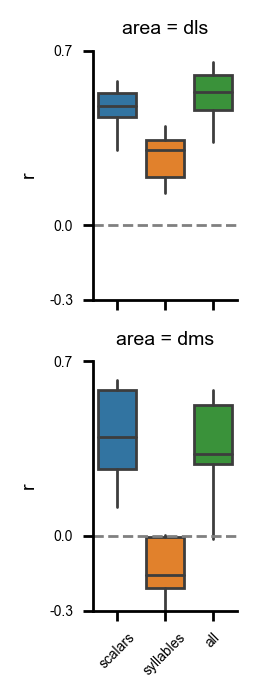

In [60]:
g = sns.catplot(
    data=plt_df.groupby(["variable", "area", "mouse_id"]).mean().reset_index(),
    x="variable",
    order=["scalars", "syllables", "all"],
    row="area",
    height=1.75,
    aspect=0.75,
    kind="box",
    showcaps=False,
    showfliers=False,
    sharey=True,
    y="r",
)
for _ax in g.axes.flat:
    _ax.tick_params("x", rotation=45)
    _ax.set_xlabel("")
g.set_titles(col_template="{col_name}")
g.set(ylim=(-0.3, 0.7))
g.refline(y=0)
clean_ticks(g.axes.flat[0], "y", precision=2, zero_symmetry=False)
savefig(
    g.fig,
    os.path.join(
        figure_cfg["store_dir"], f"encoding_model_average_syllable_v_scalars_{suffix}"
    ),
    bbox_inches="tight",
)

In [61]:
dump_data = (
    plt_df.groupby(["area", "variable", "repeat"])["r"]
    .mean()
    .groupby(["area", "variable"])
    .describe()
)

In [62]:
grouped_data = plt_df.groupby(["area", "variable", "repeat"])["r"].mean()

In [63]:
use_test = mannwhitneyu

In [64]:
stats = {}
stats["compare_r"] = {}
variables = grouped_data.index.get_level_values("variable").unique()
for _area in grouped_data.index.get_level_values("area").unique():
    stats["compare_r"][_area] = {}

    for _var1 in variables:
        for _var2 in variables:
            stat, p = use_test(
                grouped_data.loc[_area, _var1], grouped_data.loc[_area, _var2]
            )
            comparison = f"{_var1}-{_var2}"
            stats["compare_r"][_area][comparison] = {}
            stats["compare_r"][_area][comparison]["stat"] = stat
            stats["compare_r"][_area][comparison]["p"] = p
            stats["compare_r"][_area][comparison]["test"] = str(use_test.__name__)
            stats["compare_r"][_area][comparison]["n"] = (
                splits.get_n_splits() / splits.cvargs["n_splits"]
            )
            stats["compare_r"][_area][comparison][
                "n_definition"
            ] = "Average r over repeated k-fold splits"

In [65]:
concat_predictions_all = {k: np.concatenate(v) for k, v in predictions.items()}
concat_predictions_scalars = {
    k: np.concatenate(v) for k, v in predictions_scalars.items()
}
concat_predictions_syllables = {
    k: np.concatenate(v) for k, v in predictions_syllables.items()
}
concat_actual_values = {k: np.concatenate(v) for k, v in actual_values.items()}

In [67]:
dfs = []
for k, v in concat_predictions_all.items():
    _df = pd.DataFrame(data=v, columns=["prediction"])
    _df["indicator"] = [k] * len(v)
    _df["actual_value"] = concat_actual_values[k]
    _df["type"] = "all"
    dfs.append(_df)

for k, v in concat_predictions_syllables.items():
    _df = pd.DataFrame(data=v, columns=["prediction"])
    _df["indicator"] = [k] * len(v)
    _df["actual_value"] = concat_actual_values[k]
    _df["type"] = "syllable"
    dfs.append(_df)

for k, v in concat_predictions_scalars.items():
    _df = pd.DataFrame(data=v, columns=["prediction"])
    _df["indicator"] = [k] * len(v)
    _df["actual_value"] = concat_actual_values[k]
    _df["type"] = "scalar"
    dfs.append(_df)

In [68]:
prediction_df = pd.concat(dfs).reset_index(drop=True)
prediction_df_expand_indicator = (
    prediction_df["indicator"]
    .apply(pd.Series)
    .rename(
        columns=dict(
            list(zip(np.arange(len(indicator_variables)), indicator_variables))
        )
    )
)
prediction_df = prediction_df.drop("indicator", axis=1).join(
    prediction_df_expand_indicator
)

In [69]:
shuffle_by = ["area", "mouse_id", "type"]

In [70]:
overall_r = (
    prediction_df.groupby(shuffle_by).corr().xs("actual_value", level=-1)["prediction"]
)
indicators = list(overall_r.index)

In [71]:
overall_r.groupby(["area", "type"]).mean()

area  type    
dls   all         0.462067
      scalar      0.394343
      syllable    0.216737
dms   all         0.289860
      scalar      0.349807
      syllable   -0.154077
Name: prediction, dtype: float64

In [72]:
rng = np.random.default_rng(0)

In [73]:
use_prediction_df = prediction_df.set_index(overall_r.index.names)
types = use_prediction_df.index.get_level_values("type").unique()

In [74]:
nshuffles = 1000

In [75]:
dcts = []
shuffles = {}
for _indicator in tqdm(indicators):
    shuffles[_area] = []
    for _shuffle in range(nshuffles):
        use_vals = use_prediction_df.xs(_indicator)
        x = use_vals["actual_value"]
        y = use_vals["prediction"]
        r, p = pearsonr(x, rng.permutation(y))
        dct = {"indicator": _indicator, "r": r, "shuffle": _shuffle}
        dcts.append(dct)

  0%|          | 0/66 [00:00<?, ?it/s]

/tmp/ipykernel_1443209/342572105.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  use_vals = use_prediction_df.xs(_indicator)


In [76]:
shuffle_df = pd.DataFrame(dcts)
shuffle_df_expand_indicator = (
    shuffle_df["indicator"]
    .apply(pd.Series)
    .rename(
        columns=dict(list(zip(np.arange(len(overall_r.index)), overall_r.index.names)))
    )
)
shuffle_df = shuffle_df.drop("indicator", axis=1).join(shuffle_df_expand_indicator)

In [77]:
shuffle_bins = np.linspace(-0.2, 0.2, 100)

In [78]:
def get_z(x, y, bw_adjust=1):
    from scipy.stats import gaussian_kde

    xy = np.vstack([x, y])
    kernel = gaussian_kde(xy)
    kernel.set_bandwidth(kernel.scotts_factor() * bw_adjust)
    z = kernel(xy)
    return z

In [79]:
area_r = overall_r.groupby(["type", "area"]).mean()

In [80]:
area_shuffle_r = shuffle_df.groupby(["type", "area", "shuffle"]).mean()["r"]

/tmp/ipykernel_1443209/2505686104.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  area_shuffle_r = shuffle_df.groupby(["type", "area", "shuffle"]).mean()["r"]


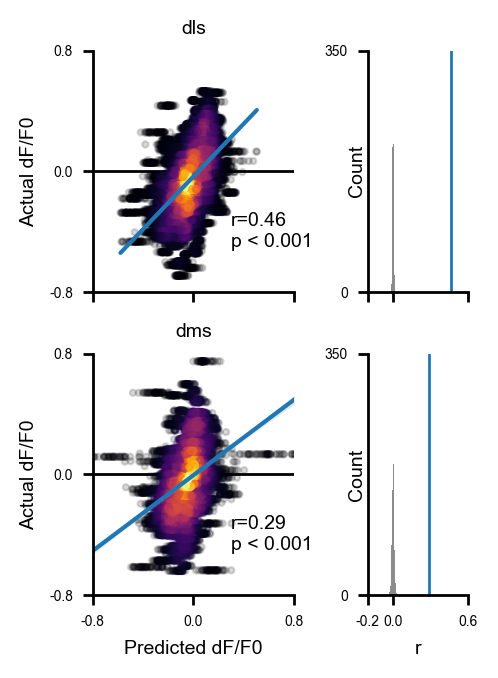

In [81]:
fig, ax = plt.subplots(
    2,
    2,
    figsize=(2.5, 3.4),
    gridspec_kw={"width_ratios": [2, 1]},
    sharex="col",
    sharey="col",
)
for _area, rax in zip(["dls", "dms"], ax):

    data = prediction_df.loc[
        (prediction_df["area"] == _area) & (prediction_df["type"] == "all")
    ]
    x = data["prediction"].values
    y = data["actual_value"].values

    z = get_z(x, y, 1)
    z /= z.max()

    rax[0].scatter(
        x,
        y,
        c=z,
        s=5,
        cmap="inferno",
        alpha=np.clip(z, 0.15, 0.8),
        rasterized=True,
        clip_on=True,
    )

    sns.regplot(
        data=data,
        x="prediction",
        y="actual_value",
        scatter=False,
        ax=rax[0],
    )

    rax[0].axhline(y=0, zorder=-300, color=plt.rcParams["axes.edgecolor"])
    rax[0].set_title(_area)
    rax[0].set_ylabel("Actual dF/F0")
    rax[0].set_xlabel("Predicted dF/F0")
    r = area_r.loc["all", _area]
    p = (r < area_shuffle_r.loc["all", _area]).mean()

    rax[0].text(0.3, -0.5, f"r={r:.02f}\n{format_pval(p)[0]}", fontsize=7)
    sns.histplot(
        area_shuffle_r.loc["all", _area],
        ax=rax[1],
        bins=shuffle_bins,
        color=[0.4, 0.4, 0.4],
        element="step",
        fill=True,
        ec=None,
        lw=0,
    )

    rax[1].axvline(x=area_r.loc["all", _area])
    rax[1].set_ylabel(rax[1].get_ylabel(), labelpad=-15)
    rax[1].set_xlim(-0.2, 0.55)
rax[0].set_xlim(-0.75, 0.75)
rax[0].set_ylim(-0.75, 0.75)

ax[0][0].set_xlabel("")
clean_ticks(rax[0], "x", precision=1, dtype=float, zero_symmetry=True)
clean_ticks(rax[0], "y", precision=1, dtype=float, zero_symmetry=True)
clean_ticks(rax[1], "y", precision=-1, dtype=int)
clean_ticks(rax[1], "x", precision=1, dtype=float, zero_symmetry=False)
fig.tight_layout()
sns.despine()
savefig(
    fig,
    os.path.join(
        figure_cfg["store_dir"],
        f"encoding_model_average_predictions_scatter_{suffix}_inverse",
    ),
    bbox_inches="tight",
    dpi=900,
)

In [82]:
area_r

type      area
all       dls     0.462067
          dms     0.289860
scalar    dls     0.394343
          dms     0.349807
syllable  dls     0.216737
          dms    -0.154077
Name: prediction, dtype: float64

In [83]:
list(area_r.items())

[(('all', 'dls'), 0.4620674944869442),
 (('all', 'dms'), 0.2898602224223845),
 (('scalar', 'dls'), 0.39434304272306914),
 (('scalar', 'dms'), 0.3498067312230658),
 (('syllable', 'dls'), 0.21673695362416043),
 (('syllable', 'dms'), -0.1540766606336678)]

In [84]:
# stats["grand_r"] = {}
stats["n"] = {}

for k, v in area_r.items():
    _type, _area = k
    r = v
    use_key = f"grand_r_{_type}_{_area}"
    stats[use_key] = {}
    stats[use_key]["r"] = r
    stats[use_key]["p"] = (r < area_shuffle_r.loc[k]).mean()
    stats[use_key]["test"] = "Comparison to shuffle"
    stats["n"] = len(use_model_features.xs(_area, level="area"))
    stats["n_definition"] = "Mouse/syllable pairs per time bin"

In [85]:
with open(
    os.path.join(proc_dirs["dlight"], "stats_encoding_model_average_variant.toml"), "w"
) as f:
    toml.dump(stats, f)

In [86]:
plt_df.to_parquet(
    os.path.join(proc_dirs["dlight"], "encoding_model_average_variant_results.parquet")
)